# Quickstart or _"How to get 100% return per year"_

First, do some initialization and set debugging level to `debug` to see progress of computation.

In [18]:
%matplotlib inline
import pandas as pd
from universal import tools
from universal import algos
import logging
# we would like to see algos progress
logging.basicConfig(format='%(asctime)s %(message)s', level=logging.DEBUG)

import matplotlib
# increase the size of graphs
matplotlib.rcParams['savefig.dpi'] = 72*1.5
matplotlib.rcParams['figure.figsize'] = [16,8]

Let's try to replicate the results of B.Li and S.Hoi from their article [On-Line Portfolio Selection with Moving Average Reversion](http://arxiv.org/abs/1206.4626). They claim superior performance on several datasets using their OLMAR algorithm. These datasets are available in `data/` directory in `.pkl` format. Those are all relative prices (start with 1.) and artificial tickers. We can start with NYSE stocks from period 1/1/1985 - 30/6/2010.

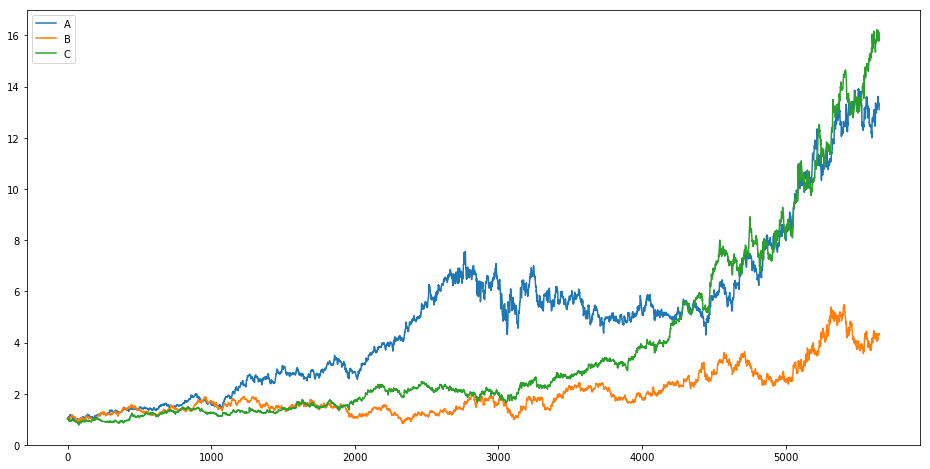

In [19]:
# load data using tools module
data = tools.dataset('nyse_o')

# plot first three of them as example
_=data.iloc[:,:3].plot()

Now we need an implementation of the OLMAR algorithm. Fortunately, it is already implemented in module `algos`, so all we have to do is load it and set its parameters. Authors recommend lookback window $w = 5$ and threshold $\epsilon = 10$ (these are default parameters anyway). Just call `run` method on our data to get results for analysis.

In [20]:
# set algo parameters
algo = algos.OLMAR(window=5, eps=10)

# run
result = algo.run(data)

2018-02-17 13:31:52,187 Running OLMAR...
2018-02-17 13:31:53,150 Progress: 10%...
2018-02-17 13:31:54,060 Progress: 20%...
2018-02-17 13:31:54,846 Progress: 30%...
2018-02-17 13:31:55,575 Progress: 40%...
2018-02-17 13:31:56,344 Progress: 50%...
2018-02-17 13:31:57,042 Progress: 60%...
2018-02-17 13:31:57,752 Progress: 70%...
2018-02-17 13:31:58,476 Progress: 80%...
2018-02-17 13:31:59,213 Progress: 90%...
2018-02-17 13:31:59,988 OLMAR finished successfully.


Ok, let's see some results. First print some basic summary metrics and plot portfolio equity with UCRP (uniform constant rebalanced portfolio).

2018-02-17 13:32:03,975 Running CRP...
2018-02-17 13:32:03,990 CRP finished successfully.


Summary:
    Profit factor: 1.89
    Sharpe ratio: 3.14
    Information ratio (wrt UCRP): 3.07
    Annualized return: 466.14%
    Annualized volatility: 56.69%
    Longest drawdown: 185 days
    Max drawdown: 46.29%
    Winning days: 58.3%
        


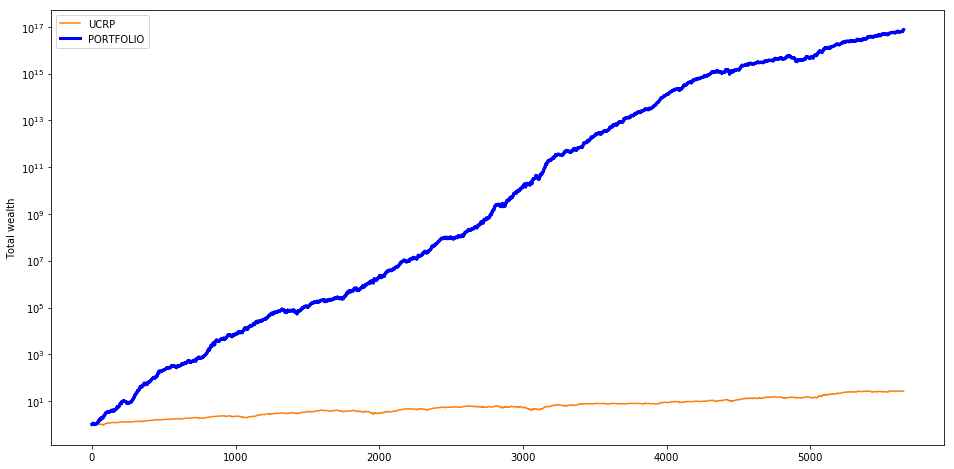

In [21]:
print(result.summary())
_=result.plot(weights=False, assets=False, ucrp=True, logy=True)

That seems really impressive, in fact it looks too good to be true. Let's see how individual stocks contribute to portfolio equity and disable legend to keep the graph clean.

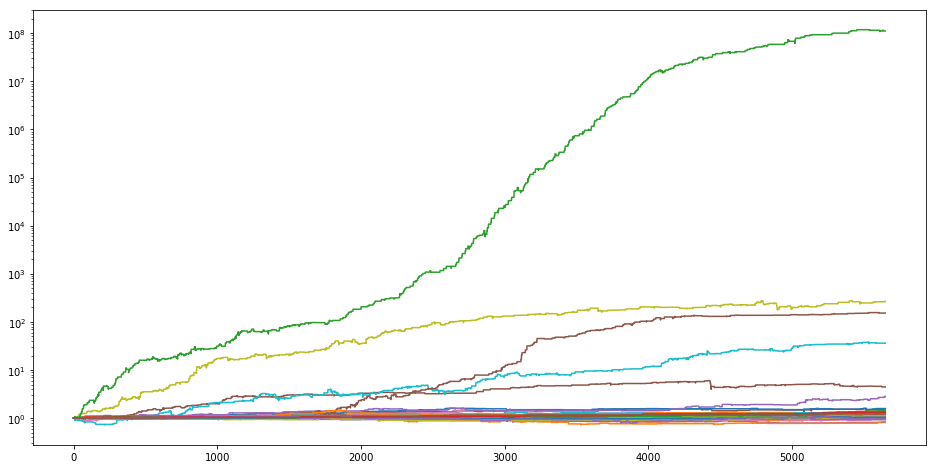

In [22]:
_=result.plot_decomposition(legend=False, logy=True)

As you can see, almost all wealth comes from single stock (don't forget it has logarithm scale!). So if we used just 5 of all these stocks, we would get almost the same equity as if we used all of them. To stress test the strategy, we can remove that stock and rerun the algorithm.

/Users/mark/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  
2018-02-17 13:32:25,353 Running OLMAR...
2018-02-17 13:32:26,178 Progress: 10%...
2018-02-17 13:32:27,061 Progress: 20%...
2018-02-17 13:32:27,870 Progress: 30%...
2018-02-17 13:32:28,700 Progress: 40%...
2018-02-17 13:32:29,466 Progress: 50%...
2018-02-17 13:32:30,227 Progress: 60%...
2018-02-17 13:32:30,972 Progress: 70%...
2018-02-17 13:32:31,704 Progress: 80%...
2018-02-17 13:32:32,446 Progress: 90%...
2018-02-17 13:32:33,217 OLMAR finished successfully.
2018-02-17 13:32:33,410 Running CRP...
2018-02-17 13:32:33,428 CRP finished successfully.


Summary:
    Profit factor: 1.55
    Sharpe ratio: 2.28
    Information ratio (wrt UCRP): 2.16
    Annualized return: 192.81%
    Annualized volatility: 47.90%
    Longest drawdown: 202 days
    Max drawdown: 45.91%
    Winning days: 56.5%
        


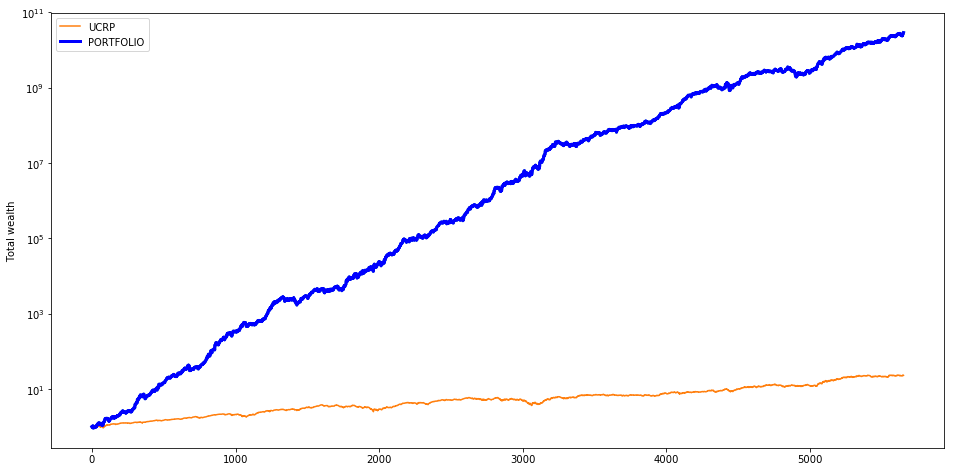

In [23]:
# find name of the most profitable asset
most_profitable = result.equity_decomposed.iloc[-1].argmax()

# rerun an algorithm on data without it
result_without = algo.run(data.drop([most_profitable], 1))

# and print results
print(result_without.summary())
_=result_without.plot(weights=False, assets=False, ucrp=True, logy=True)

We lost about 7 orders of wealth, but the results are more realistic now. Let's move on and try adding fees of 0.1% per transaction (we pay \$1 for every \$1000 of stocks bought or sold).

2018-02-17 13:32:45,844 Running CRP...


Summary:
    Profit factor: 1.35
    Sharpe ratio: 1.59
    Information ratio (wrt UCRP): 1.40
    Annualized return: 108.72%
    Annualized volatility: 47.17%
    Longest drawdown: 382 days
    Max drawdown: 50.09%
    Winning days: 50.2%
        


2018-02-17 13:32:45,860 CRP finished successfully.


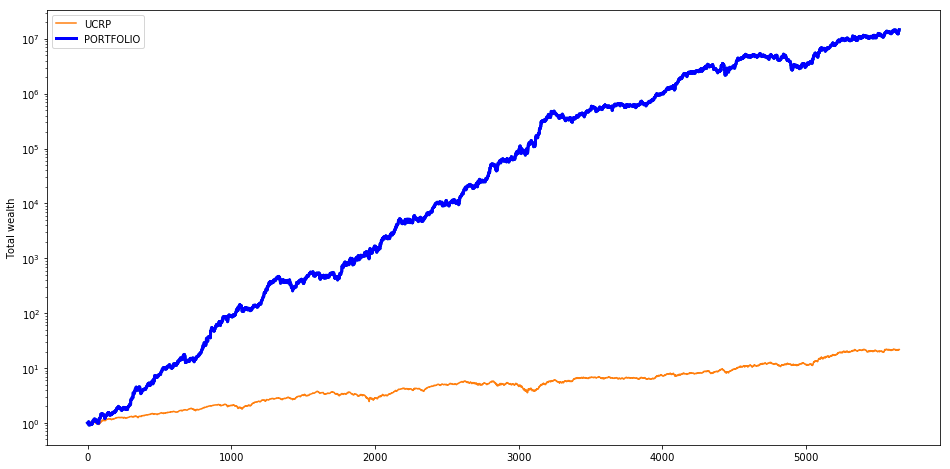

In [24]:
result_without.fee = 0.001
print(result_without.summary())
_=result_without.plot(weights=False, assets=False, ucrp=True, logy=True)

Results still hold, although our Sharpe ratio decreased from 3.14 to 1.56 and annualized return from 466% to 109%. Now some of you trained in quantitative finance might start asking: "_Isn't there some [survivorship bias](http://en.wikipedia.org/wiki/Survivorship_bias)?_". Yes, it is. In fact, a huge one considering that we have almost 25 years of data and mean-reversion type of strategy.

# Testing Yahoo data

Let's see whether the algo works on recent data, too. First download closing prices of several (randomly chosen) stocks from Yahoo.

/Users/mark/anaconda/lib/python2.7/site-packages/pandas_datareader/google/daily.py:40: UnstableAPIWarning: 
The Google Finance API has not been stable since late 2017. Requests seem
to fail at random. Failure is especially common when bulk downloading.

  warnings.warn(UNSTABLE_WARNING, UnstableAPIWarning)
2018-02-17 13:34:43,328 Starting new HTTPS connection (1): finance.google.com
2018-02-17 13:34:43,897 https://finance.google.com:443 "GET /finance/historical?q=MSFT&startdate=Jan+01%2C+2005&enddate=Feb+17%2C+2018&output=csv HTTP/1.1" 200 None
2018-02-17 13:34:44,817 https://finance.google.com:443 "GET /finance/historical?q=IBM&startdate=Jan+01%2C+2005&enddate=Feb+17%2C+2018&output=csv HTTP/1.1" 200 None
2018-02-17 13:34:45,554 https://finance.google.com:443 "GET /finance/historical?q=AAPL&startdate=Jan+01%2C+2005&enddate=Feb+17%2C+2018&output=csv HTTP/1.1" 200 None
2018-02-17 13:34:46,365 https://finance.google.com:443 "GET /finance/historical?q=GOOG&startdate=Jan+01%2C+2005&enddate=

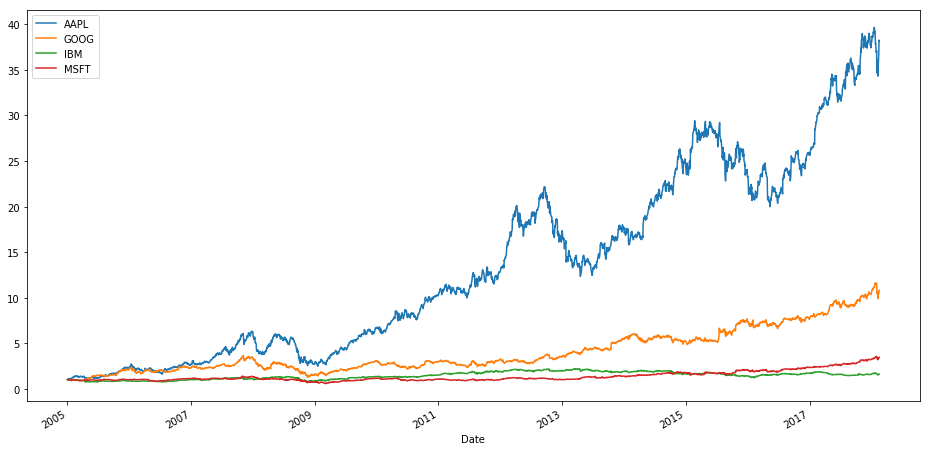

In [29]:
import pandas_datareader.data as web
from datetime import datetime

# load data from Yahoo
#yahoo_data = web.DataReader(['MSFT', 'IBM', 'AAPL', 'GOOG'], 'yahoo', start=datetime(2005,1,1))['Adj Close']
yahoo_data = web.DataReader(['MSFT', 'IBM', 'AAPL', 'GOOG'], 'google', start=datetime(2005,1,1))['Close']

# plot normalized prices of these stocks
(yahoo_data / yahoo_data.iloc[0,:]).plot()

Instead of using fixed parameters, we will test several `window` parameters with function `run_combination`. It the same as `run`, just use it as classmethod and use lists for combination of values. `run_combination` returns list of results which can be used similarly to `result`.

In [41]:
type(yahoo_data.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [35]:
yahoo_data.tail()

,AAPL,GOOG,IBM,MSFT
Date,,,,
2018-02-12,162.71,1051.94,151.40,89.13
2018-02-13,164.34,1052.10,150.75,89.83
2018-02-14,167.37,1069.70,154.76,90.81
2018-02-15,172.99,1089.52,156.01,92.66
2018-02-16,172.43,1094.80,156.18,92.00


2018-02-17 14:00:24,163 Run combination of parameters: {'window': 3, 'eps': 10}
2018-02-17 14:00:24,168 Run combination of parameters: {'window': 5, 'eps': 10}
2018-02-17 14:00:24,176 Running OLMAR...
2018-02-17 14:00:24,179 Running OLMAR...
2018-02-17 14:00:24,177 Run combination of parameters: {'window': 10, 'eps': 10}
2018-02-17 14:00:24,184 Run combination of parameters: {'window': 15, 'eps': 10}
2018-02-17 14:00:24,209 Running OLMAR...
2018-02-17 14:00:24,213 Running OLMAR...
2018-02-17 14:00:25,467 Progress: 10%...
2018-02-17 14:00:25,470 Progress: 10%...
2018-02-17 14:00:25,501 Progress: 10%...
2018-02-17 14:00:25,574 Progress: 10%...
2018-02-17 14:00:26,465 Progress: 20%...
2018-02-17 14:00:26,558 Progress: 20%...
2018-02-17 14:00:26,561 Progress: 20%...
2018-02-17 14:00:26,679 Progress: 20%...
2018-02-17 14:00:27,888 Progress: 30%...
2018-02-17 14:00:27,970 Progress: 30%...
2018-02-17 14:00:27,991 Progress: 30%...
2018-02-17 14:00:28,073 Progress: 30%...
2018-02-17 14:00:28,96

Summary for window=3:
    Profit factor: 1.09
    Sharpe ratio: 0.43
    Information ratio (wrt UCRP): -0.17
    Annualized return: 13.91%
    Annualized volatility: 30.55%
    Longest drawdown: 802 days
    Max drawdown: 51.94%
    Winning days: 50.5%
        
Summary for window=5:
    Profit factor: 1.11
    Sharpe ratio: 0.54
    Information ratio (wrt UCRP): -0.01
    Annualized return: 17.58%
    Annualized volatility: 30.19%
    Longest drawdown: 924 days
    Max drawdown: 50.13%
    Winning days: 51.3%
        
Summary for window=10:
    Profit factor: 1.16
    Sharpe ratio: 0.76
    Information ratio (wrt UCRP): 0.31
    Annualized return: 24.99%
    Annualized volatility: 29.53%
    Longest drawdown: 428 days
    Max drawdown: 53.66%
    Winning days: 51.4%
        
Summary for window=15:
    Profit factor: 1.10
    Sharpe ratio: 0.51
    Information ratio (wrt UCRP): -0.05
    Annualized return: 16.49%
    Annualized volatility: 29.74%
    Longest drawdown: 960 days
    Max d

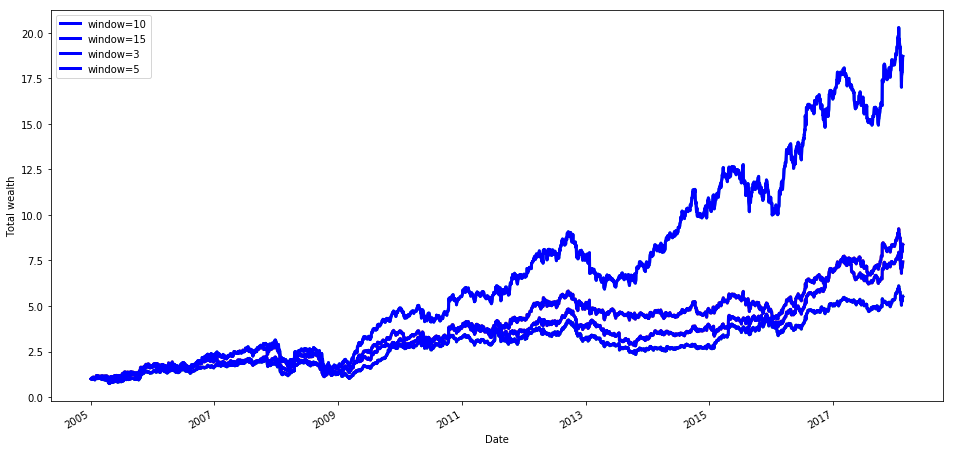

In [36]:
list_result = algos.OLMAR.run_combination(yahoo_data, window=[3,5,10,15], eps=10)
print(list_result.summary())
list_result.plot()

Since we don't know the best parameters in hindsight, we will invest equal money in each of them in the beginning and let them run. This is called _buy and hold_ strategy. Portfolio equities in `list_result` can be regarded as stock prices and used as an input for new algo (_buy and hold_ in this case). This way you can chain algorithms however you like, for example OLMAR on OLMAR, etc.

To compare it with individual assets or uniform constant rebalanced portfolio, use parameters `assets` and `ucrp`.

2018-02-17 14:01:35,749 Running BAH...
2018-02-17 14:01:35,760 BAH finished successfully.
2018-02-17 14:01:35,911 Running CRP...
2018-02-17 14:01:35,916 CRP finished successfully.


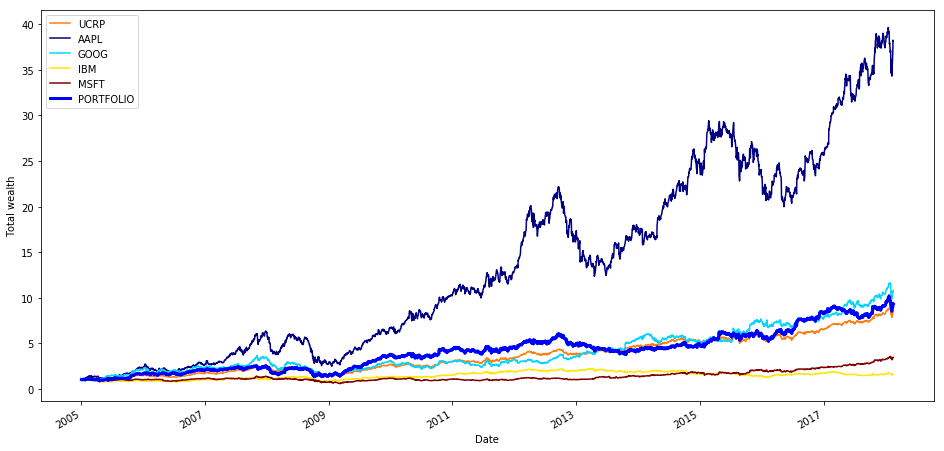

In [38]:
# run buy and hold on OLMAR results and show its equity together with original assets
_=algos.BAH().run(list_result).plot(assets=True, weights=False, ucrp=True)

Ok, so that was enough for the start. There are plenty of other algorithms in module `algos` collected across research papers about online-portfolios including famous [Universal portfolio](http://en.wikipedia.org/wiki/Universal_portfolio_algorithm) by Thomas Cover.

# How to write your own algorithm

Entire package is actually pretty simple. Algorithms are subclasses of base `Algo` class and methods for reporting, plotting and analysing are built on top of this class. I will illustrate it on this mean-reversion strategy

1. use logarithm of price
2. calculate difference $\delta_i$ between current price of $i$-th stock and its moving average of $n$ days
3. if $\delta_i > 0$, assign zero portfolio weight $w_i = 0$ for $i$-th stock
4. if $\delta_i < 0$, assign weight $w_i = -\delta_i$ for $i$-th stock
5. normalize all weights so that $\sum w_i = 1$

The idea is that badly performing stocks will revert to its mean and have higher returns than those above their mean. Here is the complete code, comments should be self-explanatory.

In [39]:
from universal.algo import Algo
import numpy as np

class MeanReversion(Algo):
    # use logarithm of prices
    PRICE_TYPE = 'log'
    
    def __init__(self, n):
        # length of moving average
        self.n = n
        # step function will be called after min_history days
        super(MeanReversion, self).__init__(min_history=n)
    
    
    def init_weights(self, m):
        # use zero weights for start
        return np.zeros(m)
    
    
    def step(self, x, last_b, history):
        # calculate moving average
        ma = history.iloc[-self.n:].mean()
        
        # weights
        delta = x - ma
        w = np.maximum(-delta, 0.)
        
        # normalize so that they sum to 1
        return w / sum(w)

That's all. Now let's try it on nyse data.

2018-02-17 14:01:50,193 Running MeanReversion...
2018-02-17 14:01:50,812 Progress: 10%...
2018-02-17 14:01:51,271 Progress: 20%...
2018-02-17 14:01:51,721 Progress: 30%...
2018-02-17 14:01:52,207 Progress: 40%...
2018-02-17 14:01:52,718 Progress: 50%...
2018-02-17 14:01:53,227 Progress: 60%...
2018-02-17 14:01:53,905 Progress: 70%...
2018-02-17 14:01:54,408 Progress: 80%...
2018-02-17 14:01:54,865 Progress: 90%...
2018-02-17 14:01:55,294 MeanReversion finished successfully.
2018-02-17 14:01:55,555 Running CRP...
2018-02-17 14:01:55,570 CRP finished successfully.


Summary:
    Profit factor: 1.46
    Sharpe ratio: 2.04
    Information ratio (wrt UCRP): 1.86
    Annualized return: 60.46%
    Annualized volatility: 23.47%
    Longest drawdown: 808 days
    Max drawdown: 41.29%
    Winning days: 52.4%
        


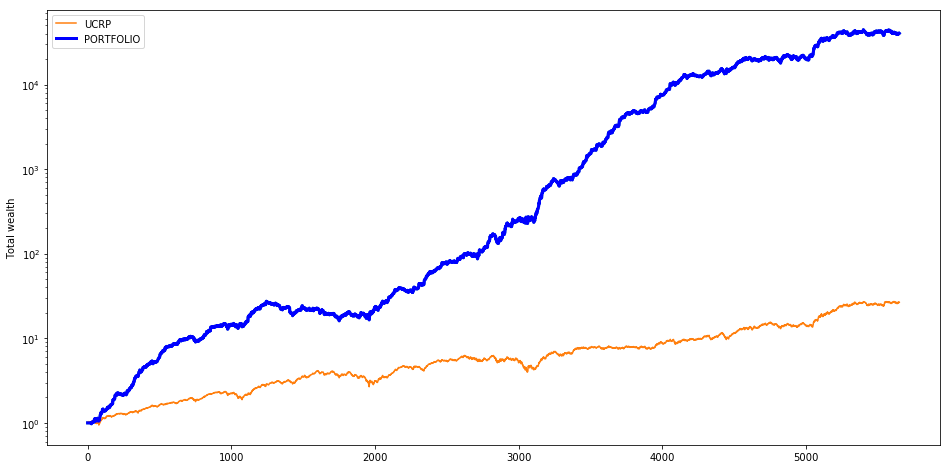

In [40]:
mr = MeanReversion(n=20)
result = mr.run(data)

print(result.summary())
result.plot(assets=False, logy=True, weights=False, ucrp=True)

Not bad considering how simple that strategy is. Next step could be performance optimization. To profile your strategy, you can use function `profile` in `universal.tools` which profile the code using fantastic [line_profiler](http://pythonhosted.org/line_profiler/). After identifying the most critical parts of the code, you have two options. Either optimize your `step` function (using tools such as [weave](http://docs.scipy.org/doc/scipy/reference/tutorial/weave.html), [numba](http://numba.pydata.org/), [theano](http://deeplearning.net/software/theano/) or [cython](http://cython.org/)) or subclass `weights` method if your code could be vectorized easily (beware the forward bias!). 